# Method 5 - Best Ideas Medium Concentration

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Herfindahl

inst_data['target_sq'] = inst_data['target'] ** 2
herf = inst_data.groupby(['datadate', 'institution_id'])['target_sq'].sum().rename('herf').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns per Shumway, Szefler, Yuan 2009

%store -r exp_ret

valid_data = valid_data.merge(exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Herf

best_ideas = best_ideas.merge(herf)
best_ideas['herf_pct'] = best_ideas.groupby('datadate')['herf'].rank(pct=True)
best_ideas = best_ideas[(best_ideas['herf_pct'] > (1 / 3)) & (best_ideas['herf_pct'] < (2 / 3))]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

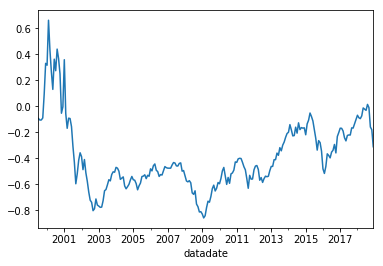

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.330613
2000-12-31   -0.250947
2001-12-31   -0.355237
2002-12-31   -0.625910
2003-12-31    1.051134
2004-12-31   -0.066191
2005-12-31    0.003132
2006-12-31    0.143032
2007-12-31   -0.041779
2008-12-31   -0.625330
2009-12-31    1.183687
2010-12-31    0.382591
2011-12-31   -0.229824
2012-12-31    0.145557
2013-12-31    0.565964
2014-12-31    0.055693
2015-12-31   -0.214544
2016-12-31    0.217590
2017-12-31    0.122103
2018-12-31   -0.230770
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     291.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.41e-88
Time:                        04:17:09   Log-Likelihood:                 394.52
No. Observations:                 234   AIC:                            -779.0
Df Residuals:                     229   BIC:                            -761.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.003      0.544      0.587      -0.004       0.008
mktrf          1.3958      0.085     16.516      0.000       1.229       1.562
me             0.6313      0.098      6.422      0.000       0.438       0.825
ia            -0.1855      0.149     -1.241      0.216      -0.480       0.109
roe           -1.3346      0.128    -10.435      0.000      -1.587      -1.083
==============================================================================
Omnibus:                      103.497   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              832.398
Skew:                           1.520   Prob(JB):                    1.77e-181
Kurtosis:                      11.725   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     95.43
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.21e-47
Time:                        04:17:09   Log-Likelihood:                 394.52
No. Observations:                 234   AIC:                            -779.0
Df Residuals:                     229   BIC:                            -761.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.003      0.557      0.577      -0.004       0.008
mktrf          1.3958      0.137     10.172      0.000       1.127       1.665
me             0.6313      0.112      5.633      0.000       0.412       0.851
ia            -0.1855      0.210     -0.883      0.377      -0.597       0.226
roe           -1.3346      0.198     -6.724      0.000      -1.724      -0.946
==============================================================================
Omnibus:                      103.497   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              832.398
Skew:                           1.520   Prob(JB):                    1.77e-181
Kurtosis:                      11.725   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     110.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.56e-52
Time:                        04:17:09   Log-Likelihood:                 394.52
No. Observations:                 234   AIC:                            -779.0
Df Residuals:                     229   BIC:                            -761.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.003      0.569      0.569      -0.004       0.007
mktrf          1.3958      0.141      9.903      0.000       1.120       1.672
me             0.6313      0.129      4.876      0.000       0.378       0.885
ia            -0.1855      0.206     -0.899      0.368      -0.590       0.219
roe           -1.3346      0.216     -6.176      0.000      -1.758      -0.911
==============================================================================
Omnibus:                      103.497   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              832.398
Skew:                           1.520   Prob(JB):                    1.77e-181
Kurtosis:                      11.725   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     205.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.55e-82
Time:                        04:17:09   Log-Likelihood:                 382.68
No. Observations:                 234   AIC:                            -753.4
Df Residuals:                     228   BIC:                            -732.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.003      0.127      0.899      -0.006       0.007
mktrf          1.5406      0.089     17.257      0.000       1.365       1.717
smb            0.6849      0.118      5.814      0.000       0.453       0.917
hml            0.1580      0.139      1.138      0.256      -0.116       0.432
rmw           -1.2000      0.157     -7.641      0.000      -1.509      -0.891
cma           -0.0475      0.200     -0.238      0.812      -0.441       0.346
==============================================================================
Omnibus:                      103.930   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              549.840
Skew:                           1.697   Prob(JB):                    4.02e-120
Kurtosis:                       9.699   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     149.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.21e-70
Time:                        04:17:09   Log-Likelihood:                 382.68
No. Observations:                 234   AIC:                            -753.4
Df Residuals:                     228   BIC:                            -732.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.003      0.133      0.894      -0.006       0.007
mktrf          1.5406      0.084     18.264      0.000       1.375       1.706
smb            0.6849      0.125      5.489      0.000       0.440       0.929
hml            0.1580      0.246      0.643      0.520      -0.323       0.639
rmw           -1.2000      0.221     -5.423      0.000      -1.634      -0.766
cma           -0.0475      0.347     -0.137      0.891      -0.728       0.633
==============================================================================
Omnibus:                      103.930   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              549.840
Skew:                           1.697   Prob(JB):                    4.02e-120
Kurtosis:                       9.699   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     170.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.10e-75
Time:                        04:17:09   Log-Likelihood:                 382.68
No. Observations:                 234   AIC:                            -753.4
Df Residuals:                     228   BIC:                            -732.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.003      0.133      0.894      -0.006       0.007
mktrf          1.5406      0.077     20.121      0.000       1.391       1.691
smb            0.6849      0.122      5.622      0.000       0.446       0.924
hml            0.1580      0.217      0.730      0.466      -0.267       0.583
rmw           -1.2000      0.242     -4.950      0.000      -1.675      -0.725
cma           -0.0475      0.339     -0.140      0.889      -0.711       0.616
==============================================================================
Omnibus:                      103.930   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              549.840
Skew:                           1.697   Prob(JB):                    4.02e-120
Kurtosis:                       9.699   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     275.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.52e-86
Time:                        04:17:09   Log-Likelihood:                 389.21
No. Observations:                 234   AIC:                            -768.4
Df Residuals:                     229   BIC:                            -751.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0027      0.003     -0.883      0.378      -0.009       0.003
mktrf          1.5879      0.080     19.949      0.000       1.431       1.745
smb            1.2678      0.099     12.760      0.000       1.072       1.464
hml           -0.1810      0.099     -1.834      0.068      -0.375       0.013
umd           -0.5421      0.065     -8.370      0.000      -0.670      -0.414
==============================================================================
Omnibus:                       70.388   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              392.973
Skew:                           1.043   Prob(JB):                     4.65e-86
Kurtosis:                       8.996   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     149.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.21e-62
Time:                        04:17:09   Log-Likelihood:                 389.21
No. Observations:                 234   AIC:                            -768.4
Df Residuals:                     229   BIC:                            -751.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0027      0.003     -0.923      0.356      -0.009       0.003
mktrf          1.5879      0.109     14.568      0.000       1.374       1.802
smb            1.2678      0.107     11.819      0.000       1.058       1.478
hml           -0.1810      0.152     -1.193      0.233      -0.478       0.116
umd           -0.5421      0.086     -6.298      0.000      -0.711      -0.373
==============================================================================
Omnibus:                       70.388   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              392.973
Skew:                           1.043   Prob(JB):                     4.65e-86
Kurtosis:                       8.996   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     127.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.21e-57
Time:                        04:17:09   Log-Likelihood:                 389.21
No. Observations:                 234   AIC:                            -768.4
Df Residuals:                     229   BIC:                            -751.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0027      0.003     -0.978      0.328      -0.008       0.003
mktrf          1.5879      0.104     15.200      0.000       1.383       1.793
smb            1.2678      0.113     11.248      0.000       1.047       1.489
hml           -0.1810      0.145     -1.249      0.212      -0.465       0.103
umd           -0.5421      0.086     -6.314      0.000      -0.710      -0.374
==============================================================================
Omnibus:                       70.388   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              392.973
Skew:                           1.043   Prob(JB):                     4.65e-86
Kurtosis:                       8.996   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     135.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.70e-42
Time:                        04:17:09   Log-Likelihood:                 178.94
No. Observations:                 120   AIC:                            -347.9
Df Residuals:                     115   BIC:                            -333.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.005      0.860      0.391      -0.006       0.015
mktrf          1.2736      0.143      8.880      0.000       0.989       1.558
me             0.5183      0.142      3.659      0.000       0.238       0.799
ia            -0.3514      0.222     -1.584      0.116      -0.791       0.088
roe           -1.4128      0.196     -7.196      0.000      -1.802      -1.024
==============================================================================
Omnibus:                       40.417   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              141.369
Skew:                           1.140   Prob(JB):                     2.00e-31
Kurtosis:                       7.804   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     81.01
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.53e-32
Time:                        04:17:09   Log-Likelihood:                 178.94
No. Observations:                 120   AIC:                            -347.9
Df Residuals:                     115   BIC:                            -333.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.005      0.932      0.351      -0.005       0.014
mktrf          1.2736      0.204      6.241      0.000       0.874       1.673
me             0.5183      0.148      3.511      0.000       0.229       0.808
ia            -0.3514      0.295     -1.190      0.234      -0.930       0.227
roe           -1.4128      0.273     -5.168      0.000      -1.949      -0.877
==============================================================================
Omnibus:                       40.417   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              141.369
Skew:                           1.140   Prob(JB):                     2.00e-31
Kurtosis:                       7.804   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     108.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.27e-38
Time:                        04:17:09   Log-Likelihood:                 178.94
No. Observations:                 120   AIC:                            -347.9
Df Residuals:                     115   BIC:                            -333.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.004      1.028      0.304      -0.004       0.013
mktrf          1.2736      0.212      6.017      0.000       0.859       1.688
me             0.5183      0.168      3.081      0.002       0.189       0.848
ia            -0.3514      0.293     -1.198      0.231      -0.926       0.224
roe           -1.4128      0.304     -4.646      0.000      -2.009      -0.817
==============================================================================
Omnibus:                       40.417   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              141.369
Skew:                           1.140   Prob(JB):                     2.00e-31
Kurtosis:                       7.804   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     95.16
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.01e-39
Time:                        04:17:09   Log-Likelihood:                 173.14
No. Observations:                 120   AIC:                            -334.3
Df Residuals:                     114   BIC:                            -317.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.006      0.799      0.426      -0.007       0.016
mktrf          1.5917      0.159      9.985      0.000       1.276       1.908
smb            0.6197      0.181      3.432      0.001       0.262       0.977
hml           -0.0866      0.221     -0.391      0.696      -0.525       0.352
rmw           -1.0595      0.261     -4.061      0.000      -1.576      -0.543
cma            0.0233      0.286      0.081      0.935      -0.543       0.589
==============================================================================
Omnibus:                       53.435   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              159.505
Skew:                           1.669   Prob(JB):                     2.31e-35
Kurtosis:                       7.556   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     53.39
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.70e-28
Time:                        04:17:09   Log-Likelihood:                 173.14
No. Observations:                 120   AIC:                            -334.3
Df Residuals:                     114   BIC:                            -317.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.005      0.989      0.322      -0.005       0.014
mktrf          1.5917      0.152     10.483      0.000       1.294       1.889
smb            0.6197      0.176      3.530      0.000       0.276       0.964
hml           -0.0866      0.260     -0.333      0.739      -0.595       0.422
rmw           -1.0595      0.294     -3.602      0.000      -1.636      -0.483
cma            0.0233      0.403      0.058      0.954      -0.767       0.813
==============================================================================
Omnibus:                       53.435   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              159.505
Skew:                           1.669   Prob(JB):                     2.31e-35
Kurtosis:                       7.556   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     61.65
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.10e-31
Time:                        04:17:09   Log-Likelihood:                 173.14
No. Observations:                 120   AIC:                            -334.3
Df Residuals:                     114   BIC:                            -317.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.004      1.056      0.291      -0.004       0.013
mktrf          1.5917      0.130     12.279      0.000       1.338       1.846
smb            0.6197      0.164      3.772      0.000       0.298       0.942
hml           -0.0866      0.242     -0.358      0.720      -0.561       0.387
rmw           -1.0595      0.328     -3.228      0.001      -1.703      -0.416
cma            0.0233      0.387      0.060      0.952      -0.735       0.781
==============================================================================
Omnibus:                       53.435   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              159.505
Skew:                           1.669   Prob(JB):                     2.31e-35
Kurtosis:                       7.556   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     144.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.27e-44
Time:                        04:17:09   Log-Likelihood:                 182.39
No. Observations:                 120   AIC:                            -354.8
Df Residuals:                     115   BIC:                            -340.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.005      0.039      0.969      -0.010       0.010
mktrf          1.5872      0.123     12.929      0.000       1.344       1.830
smb            1.2242      0.140      8.758      0.000       0.947       1.501
hml           -0.3963      0.140     -2.831      0.005      -0.674      -0.119
umd           -0.5382      0.086     -6.235      0.000      -0.709      -0.367
==============================================================================
Omnibus:                       36.520   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.824
Skew:                           1.002   Prob(JB):                     3.91e-29
Kurtosis:                       7.707   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     131.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.27e-42
Time:                        04:17:09   Log-Likelihood:                 182.39
No. Observations:                 120   AIC:                            -354.8
Df Residuals:                     115   BIC:                            -340.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.005      0.043      0.965      -0.009       0.009
mktrf          1.5872      0.163      9.747      0.000       1.268       1.906
smb            1.2242      0.131      9.367      0.000       0.968       1.480
hml           -0.3963      0.198     -2.003      0.045      -0.784      -0.008
umd           -0.5382      0.084     -6.389      0.000      -0.703      -0.373
==============================================================================
Omnibus:                       36.520   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.824
Skew:                           1.002   Prob(JB):                     3.91e-29
Kurtosis:                       7.707   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     136.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.35e-43
Time:                        04:17:09   Log-Likelihood:                 182.39
No. Observations:                 120   AIC:                            -354.8
Df Residuals:                     115   BIC:                            -340.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.004      0.047      0.962      -0.008       0.008
mktrf          1.5872      0.162      9.788      0.000       1.269       1.905
smb            1.2242      0.136      9.006      0.000       0.958       1.491
hml           -0.3963      0.195     -2.028      0.043      -0.779      -0.013
umd           -0.5382      0.084     -6.437      0.000      -0.702      -0.374
==============================================================================
Omnibus:                       36.520   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.824
Skew:                           1.002   Prob(JB):                     3.91e-29
Kurtosis:                       7.707   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     195.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.66e-49
Time:                        04:17:09   Log-Likelihood:                 239.20
No. Observations:                 114   AIC:                            -468.4
Df Residuals:                     109   BIC:                            -454.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.003     -0.329      0.743      -0.007       0.005
mktrf          1.4785      0.089     16.566      0.000       1.302       1.655
me             0.8552      0.138      6.206      0.000       0.582       1.128
ia             0.0936      0.191      0.490      0.625      -0.285       0.472
roe           -1.2782      0.168     -7.611      0.000      -1.611      -0.945
==============================================================================
Omnibus:                        9.508   Durbin-Watson:                   2.099
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               11.708
Skew:                           0.473   Prob(JB):                      0.00287
Kurtosis:                       4.253   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     202.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.58e-49
Time:                        04:17:09   Log-Likelihood:                 239.20
No. Observations:                 114   AIC:                            -468.4
Df Residuals:                     109   BIC:                            -454.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.002     -0.406      0.685      -0.006       0.004
mktrf          1.4785      0.092     16.006      0.000       1.297       1.660
me             0.8552      0.162      5.289      0.000       0.538       1.172
ia             0.0936      0.203      0.462      0.644      -0.304       0.491
roe           -1.2782      0.217     -5.886      0.000      -1.704      -0.853
==============================================================================
Omnibus:                        9.508   Durbin-Watson:                   2.099
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               11.708
Skew:                           0.473   Prob(JB):                      0.00287
Kurtosis:                       4.253   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     222.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.73e-51
Time:                        04:17:09   Log-Likelihood:                 239.20
No. Observations:                 114   AIC:                            -468.4
Df Residuals:                     109   BIC:                            -454.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.002     -0.448      0.654      -0.005       0.003
mktrf          1.4785      0.084     17.510      0.000       1.313       1.644
me             0.8552      0.188      4.559      0.000       0.488       1.223
ia             0.0936      0.229      0.408      0.683      -0.356       0.543
roe           -1.2782      0.238     -5.381      0.000      -1.744      -0.813
==============================================================================
Omnibus:                        9.508   Durbin-Watson:                   2.099
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               11.708
Skew:                           0.473   Prob(JB):                      0.00287
Kurtosis:                       4.253   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     141.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.11e-45
Time:                        04:17:09   Log-Likelihood:                 234.48
No. Observations:                 114   AIC:                            -457.0
Df Residuals:                     108   BIC:                            -440.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0031      0.003     -0.988      0.326      -0.009       0.003
mktrf          1.5250      0.089     17.111      0.000       1.348       1.702
smb            0.7969      0.145      5.508      0.000       0.510       1.084
hml            0.5995      0.185      3.249      0.002       0.234       0.965
rmw           -1.1445      0.226     -5.066      0.000      -1.592      -0.697
cma           -0.2723      0.287     -0.949      0.345      -0.841       0.296
==============================================================================
Omnibus:                        5.295   Durbin-Watson:                   2.165
Prob(Omnibus):                  0.071   Jarque-Bera (JB):                5.660
Skew:                           0.293   Prob(JB):                       0.0590
Kurtosis:                       3.921   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     178.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.82e-50
Time:                        04:17:09   Log-Likelihood:                 234.48
No. Observations:                 114   AIC:                            -457.0
Df Residuals:                     108   BIC:                            -440.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0031      0.003     -0.986      0.324      -0.009       0.003
mktrf          1.5250      0.065     23.620      0.000       1.398       1.652
smb            0.7969      0.130      6.153      0.000       0.543       1.051
hml            0.5995      0.170      3.526      0.000       0.266       0.933
rmw           -1.1445      0.249     -4.597      0.000      -1.633      -0.657
cma           -0.2723      0.277     -0.984      0.325      -0.815       0.270
==============================================================================
Omnibus:                        5.295   Durbin-Watson:                   2.165
Prob(Omnibus):                  0.071   Jarque-Bera (JB):                5.660
Skew:                           0.293   Prob(JB):                       0.0590
Kurtosis:                       3.921   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     174.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.30e-50
Time:                        04:17:09   Log-Likelihood:                 234.48
No. Observations:                 114   AIC:                            -457.0
Df Residuals:                     108   BIC:                            -440.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0031      0.003     -1.081      0.280      -0.009       0.003
mktrf          1.5250      0.062     24.763      0.000       1.404       1.646
smb            0.7969      0.133      6.007      0.000       0.537       1.057
hml            0.5995      0.151      3.966      0.000       0.303       0.896
rmw           -1.1445      0.215     -5.321      0.000      -1.566      -0.723
cma           -0.2723      0.304     -0.896      0.370      -0.868       0.323
==============================================================================
Omnibus:                        5.295   Durbin-Watson:                   2.165
Prob(Omnibus):                  0.071   Jarque-Bera (JB):                5.660
Skew:                           0.293   Prob(JB):                       0.0590
Kurtosis:                       3.921   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     153.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.51e-44
Time:                        04:17:09   Log-Likelihood:                 227.27
No. Observations:                 114   AIC:                            -444.5
Df Residuals:                     109   BIC:                            -430.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0042      0.003     -1.267      0.208      -0.011       0.002
mktrf          1.5641      0.094     16.657      0.000       1.378       1.750
smb            1.0693      0.146      7.303      0.000       0.779       1.359
hml            0.4852      0.151      3.217      0.002       0.186       0.784
umd           -0.4193      0.114     -3.686      0.000      -0.645      -0.194
==============================================================================
Omnibus:                        9.491   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               15.474
Skew:                           0.337   Prob(JB):                     0.000436
Kurtosis:                       4.674   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     233.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.87e-52
Time:                        04:17:09   Log-Likelihood:                 227.27
No. Observations:                 114   AIC:                            -444.5
Df Residuals:                     109   BIC:                            -430.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0042      0.003     -1.396      0.163      -0.010       0.002
mktrf          1.5641      0.074     21.218      0.000       1.420       1.709
smb            1.0693      0.129      8.280      0.000       0.816       1.322
hml            0.4852      0.169      2.873      0.004       0.154       0.816
umd           -0.4193      0.130     -3.236      0.001      -0.673      -0.165
==============================================================================
Omnibus:                        9.491   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               15.474
Skew:                           0.337   Prob(JB):                     0.000436
Kurtosis:                       4.674   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     319.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.43e-59
Time:                        04:17:09   Log-Likelihood:                 227.27
No. Observations:                 114   AIC:                            -444.5
Df Residuals:                     109   BIC:                            -430.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0042      0.003     -1.593      0.111      -0.009       0.001
mktrf          1.5641      0.065     24.049      0.000       1.437       1.692
smb            1.0693      0.113      9.481      0.000       0.848       1.290
hml            0.4852      0.171      2.840      0.005       0.150       0.820
umd           -0.4193      0.129     -3.245      0.001      -0.673      -0.166
==============================================================================
Omnibus:                        9.491   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               15.474
Skew:                           0.337   Prob(JB):                     0.000436
Kurtosis:                       4.674   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""